## 基于SqueezeNet_Residual模型实现细胞识别

该项目是基于SqueezeNet_Residual算法，实现细胞类型识别，类别包括嗜碱细胞（basophil）, 成红细胞（erythroblast）, 单核细胞（monocyte）, 原始粒细胞（myeloblast）, 中性粒细胞（seg_neutrophil）。

### 环境准备

In [1]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


### 超参设置

In [3]:
batch_size = 64  # 批量大小
image_size = 64  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 5  # 分类数量

### 数据集下载及数据处理

通过git下载魔乐平台的数据集。

In [4]:
!git lfs install
!git clone https://modelers.cn/xsir/cell.git
!unzip -q cell/dataset.zip -d ./cell

Git LFS initialized.
正克隆到 'cell'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [5]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./cell/dataset/train/"
data_path_val = "./cell/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")


# # 训练数据集的前六张图片
# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"{classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()

Image shape: (64, 3, 64, 64), Label shape: (64,)
Labels: [2 3 4 2 1 0]


### SqueezeNet_Residual模型
有关SqueezeNet_Residual网络的详细情况可以参考论文https://arxiv.org/pdf/2006.00757

In [7]:
import mindspore.nn as nn
from mindspore.common import initializer as weight_init
from mindspore.ops import operations as P


class Fire(nn.Cell):
    """
    Fire network definition.
    """
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes,
                 expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes,
                                 squeeze_planes,
                                 kernel_size=1,
                                 has_bias=True)
        self.squeeze_activation = nn.ReLU()
        self.expand1x1 = nn.Conv2d(squeeze_planes,
                                   expand1x1_planes,
                                   kernel_size=1,
                                   has_bias=True)
        self.expand1x1_activation = nn.ReLU()
        self.expand3x3 = nn.Conv2d(squeeze_planes,
                                   expand3x3_planes,
                                   kernel_size=3,
                                   pad_mode='same',
                                   has_bias=True)
        self.expand3x3_activation = nn.ReLU()
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return self.concat((self.expand1x1_activation(self.expand1x1(x)),
                            self.expand3x3_activation(self.expand3x3(x))))


class SqueezeNet_Residual(nn.Cell):
    
    def __init__(self, num_classes=10):
        super(SqueezeNet_Residual, self).__init__()

        self.conv1 = nn.Conv2d(3,
                               96,
                               kernel_size=7,
                               stride=2,
                               pad_mode='valid',
                               has_bias=True)
        self.fire2 = Fire(96, 16, 64, 64)
        self.fire3 = Fire(128, 16, 64, 64)
        self.fire4 = Fire(128, 32, 128, 128)
        self.fire5 = Fire(256, 32, 128, 128)
        self.fire6 = Fire(256, 48, 192, 192)
        self.fire7 = Fire(384, 48, 192, 192)
        self.fire8 = Fire(384, 64, 256, 256)
        self.fire9 = Fire(512, 64, 256, 256)
        # Final convolution is initialized differently from the rest
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1, has_bias=True)

        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=3, stride=2)
        self.add = P.Add()
        self.dropout = nn.Dropout(p=0.5)
        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.custom_init_weight()

    def custom_init_weight(self):
        """
        Init the weight of Conv2d in the net.
        """
        for _, cell in self.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                if cell is self.conv10:
                    cell.weight.set_data(
                        weight_init.initializer('normal', cell.weight.shape,
                                                cell.weight.dtype))
                else:
                    cell.weight.set_data(
                        weight_init.initializer('xavier_uniform',
                                                cell.weight.shape,
                                                cell.weight.dtype))
                if cell.bias is not None:
                    cell.bias.set_data(
                        weight_init.initializer('zeros', cell.bias.shape,
                                                cell.bias.dtype))

    def construct(self, x):
        """
        Construct squeezenet_residual.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.fire2(x)
        x = self.add(x, self.fire3(x))
        x = self.fire4(x)
        x = self.max_pool2d(x)
        x = self.add(x, self.fire5(x))
        x = self.fire6(x)
        x = self.add(x, self.fire7(x))
        x = self.fire8(x)
        x = self.max_pool2d(x)
        x = self.add(x, self.fire9(x))
        x = self.dropout(x)
        x = self.conv10(x)
        x = self.relu(x)
        x = self.mean(x, (2, 3))
        x = self.flatten(x)

        return x


### 模型训练
跑了50epochs训练结果如下:

In [8]:
network = SqueezeNet_Residual(num_classes=5)

In [9]:
# 设置学习率
num_epochs = 50
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [10]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/SqueezeNet_Residual-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [11]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [12]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 10 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
...--------------------------------------------------
Epoch: [ 10/ 50], Average Train Loss: [1.286], Accuracy: [0.447]
--------------------------------------------------
Epoch: [ 20/ 50], Average Train Loss: [0.672], Accuracy: [0.840]
--------------------------------------------------
Epoch: [ 30/ 50], Average Train Loss: [0.523], Accuracy: [0.873]
--------------------------------------------------
Epoch: [ 40/ 50], Average Train Loss: [0.386], Accuracy: [0.907]
--------------------------------------------------
Epoch: [ 50/ 50], Average Train Loss: [0.367], Accuracy: [0.920]
End of validation the best Accuracy is:  0.927, save the best ckpt file in ./BestCheckpoint/SqueezeNet_Residual-best.ckpt


### 可视化模型预测
定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

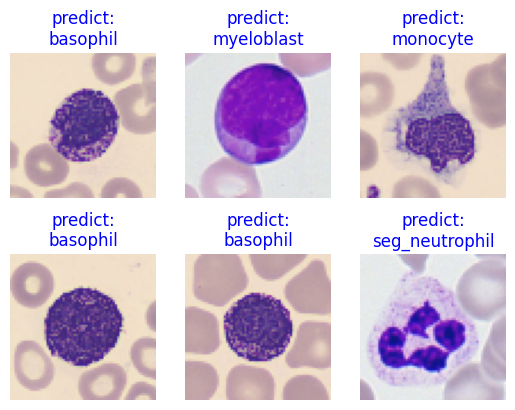

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model(best_ckpt_path, dataset_val):
    net = SqueezeNet_Residual(num_classes=5)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = ["basophil", "erythroblast", "monocyte", "myeloblast", "seg_neutrophil"]

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:\n{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)